In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import ml_utils.utils as ml_utils
import matplotlib.pyplot as plt
import numpy as np
import os

path_data = 'data'
path_train_dir = os.path.join(path_data, 'training')
path_train_label = os.path.join(path_data, 'test_set_images')

PATCH_SIZE = 16

Load data images and split them in to set (train and validation) according to seed and rato. Note that id_xxxx are the variable that store the id of the images to retreive them later.

In [2]:
im_train, lab_train, im_valid, lab_valid, id_train, id_valid = ml_utils.load_train_set(path_train_dir)

Display first image of train set. Left is satellite image and right ground truth (roads)

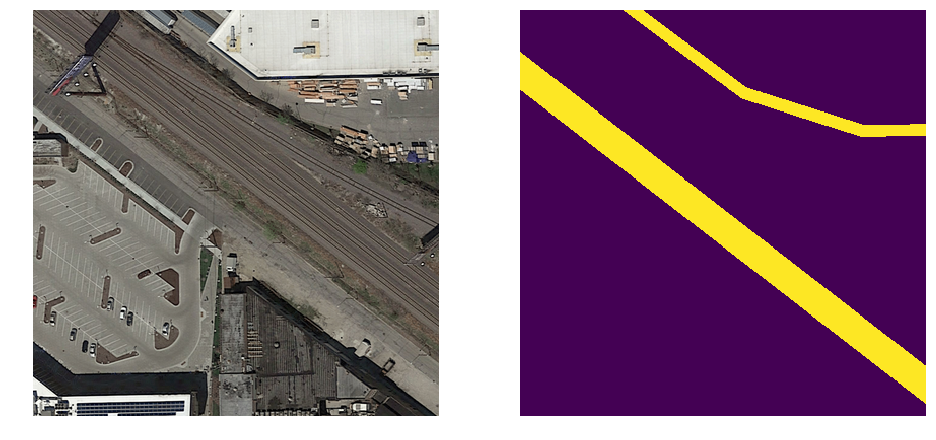

In [3]:
plt.figure(figsize=(16, 8));
plt.subplot(1,2,1); plt.imshow(im_train[0]); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(lab_train[0]); plt.axis("off")
plt.show()

Display histogram for all chanels (RGB). Note that road are more mostly present in interval [0.3, 0.6]. Which make sens since gray is a muxture of all chanels.

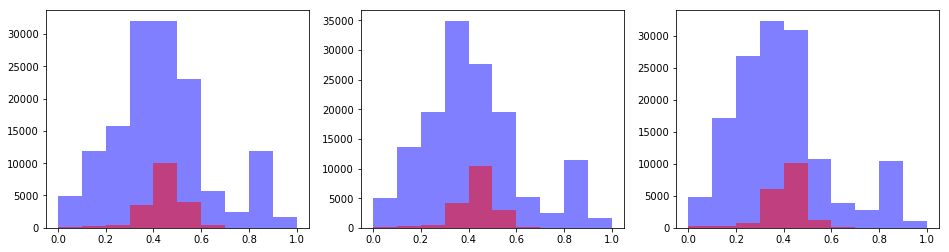

In [4]:
id_road = lab_train[0].flatten()!=0
id_background = lab_train[0].flatten()==0

plt.figure(figsize=(16,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.hist((im_train[0,:,:,i].flatten())[id_background], color='b', alpha=0.5)
    plt.hist((im_train[0,:,:,i].flatten())[id_road], color='r', alpha=0.5)

Normalize each image according to itself. Center image (mean value) and divide by norm L2.

In [5]:
im_train = ml_utils.normalize_data(im_train)
im_valid = ml_utils.normalize_data(im_valid)

Create patches of predefined sizes. Note that this size is arbitrary. It will be good to test with different settings.

In [6]:
# Convert images to batches (easier for ML task)
x_patches_tr, y_patches_tr, y_patches_lab_tr = ml_utils.get_patches_all(im_train, lab_train, PATCH_SIZE)
x_patches_val, y_patches_val, y_patches_lab_val = ml_utils.get_patches_all(im_valid, lab_valid, PATCH_SIZE)

print('Train:\nx_patches shape: {}, y_patches shape: {}, y_patches_label shape: {}'.format(
    x_patches_tr.shape, y_patches_tr.shape, y_patches_lab_tr.shape))
print('\nValidation:\nx_patches shape: {}, y_patches shape: {}, y_patches_label shape: {}'.format(
    x_patches_val.shape, y_patches_val.shape, y_patches_lab_val.shape))

Train:
x_patches shape: (50000, 16, 16, 3), y_patches shape: (50000, 16, 16), y_patches_label shape: (50000,)

Validation:
x_patches shape: (12500, 16, 16, 3), y_patches shape: (12500, 16, 16), y_patches_label shape: (12500,)


In [7]:
# Do not work beacause normalization, but if removve normalization -> Ok
# offset = 3300 
# plt.figure(figsize=(16, 5))
# for i in range(6):
#    plt.subplot(2, 6,i+1)
#    plt.imshow(x_patches_tr[offset+i]); plt.axis('off')
#    plt.subplot(2, 6, 6+i+1)
#    plt.title('Road: {:1.0f}'.format(y_patches_lab_tr[offset+i]))
#    plt.imshow(y_patches_tr[offset+i], vmin=0, vmax=1); plt.axis('off')

In [8]:
# Do not work beacause normalization, but if removve normalization -> Ok
# offset = 12
# plt.figure(figsize=(16, 5))
# for i in range(6):
#    plt.subplot(2, 6,i+1)
#    plt.imshow(x_patches_val[offset+i]); plt.axis('off')
#    plt.subplot(2, 6, 6+i+1)
#    plt.title('Road: {:1.0f}'.format(y_patches_lab_val[offset+i]))
#    plt.imshow(y_patches_val[offset+i], vmin=0, vmax=1); plt.axis('off')

Create feature set for classification based on mean and stddev value sof each patches.

In [9]:
x_train = ml_utils.create_features(x_patches_tr)
x_valid = ml_utils.create_features(x_patches_val)
y_train = y_patches_lab_tr
y_valid = y_patches_lab_val

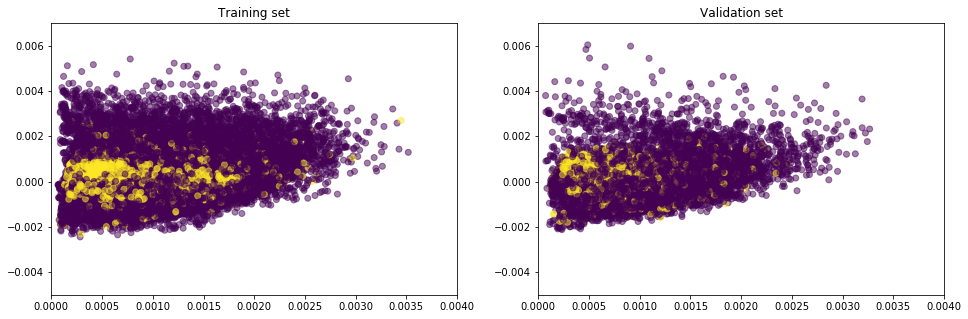

In [10]:
plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
plt.xlim([0, 4e-3]); plt.ylim([-5e-3, 7e-3]); plt.title('Training set')
plt.scatter(x_train[:,6], x_train[:,7], c=y_patches_lab_tr, alpha=0.5)
plt.subplot(1,2,2)
plt.xlim([0, 4e-3]); plt.ylim([-5e-3, 7e-3]); plt.title('Validation set')
plt.scatter(x_valid[:,6], x_valid[:,7], c=y_patches_lab_val, alpha=0.5)

Perform classification using KNN classifier. Majority voting (we can test with others)

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score

# model = LogisticRegression(C=1e5, class_weight="balanced")
# model = GaussianNB()
# model = SVC(kernel="linear")
# model = KNeighborsClassifier(n_neighbors=5)
model = RandomForestClassifier(max_depth=10, max_features=8, random_state=0)
model.fit(x_train, y_train)
y_pred_tr = model.predict(x_train)
y_pred = model.predict(x_valid)

In [12]:
print('Accuracy Train: {:.3f}, precision: {:.3f}'.format(
    accuracy_score(y_pred_tr, y_train), precision_score(y_pred_tr, y_train)))
print('Accuracy Validation: {:.3f}, precision: {:.3f}'.format(
    accuracy_score(y_pred, y_valid), precision_score(y_pred, y_valid)))

Accuracy Train: 0.835, precision: 0.276
Accuracy Validation: 0.807, precision: 0.215


Display prediction results for different images (defined by id_display)

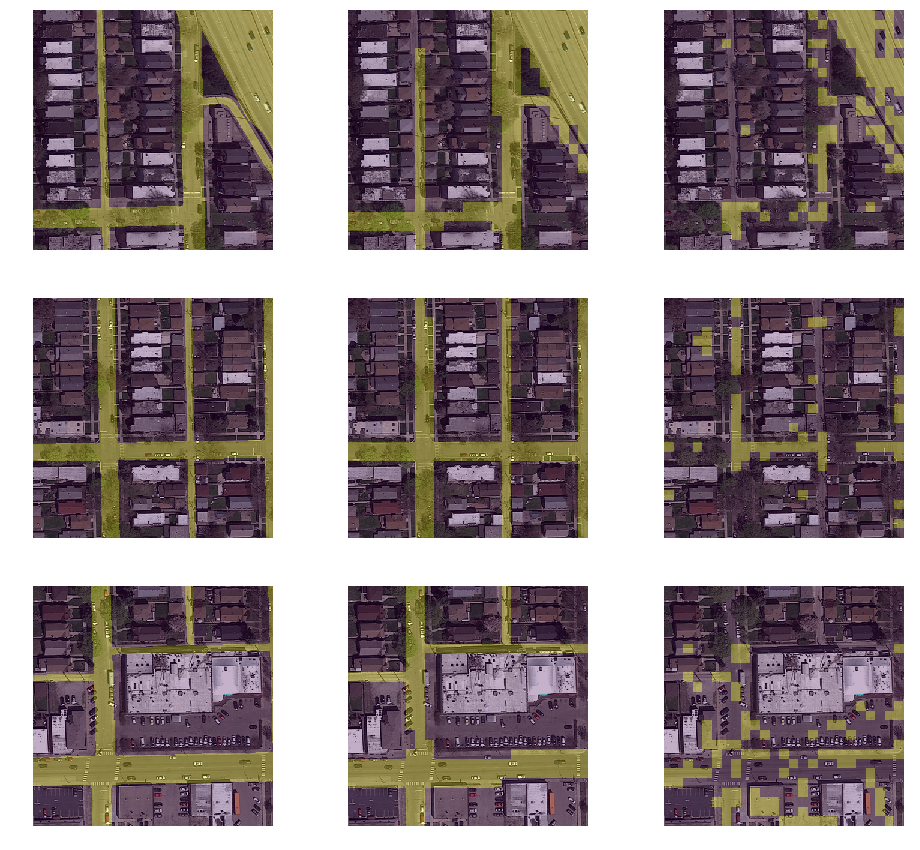

In [13]:
id_display = [0, 5, 15]

plt.figure(figsize=(16, 5*len(id_display)))
for i, id_ in enumerate(id_display):
    # Get source image and predction for current id
    im, cgt = ml_utils.load_image_train_by_id(id_valid[id_], path_train_dir)
    cgt_label = ml_utils.patches_to_img(y_valid[id_*(25*25):(id_+1)*(25*25)], im.shape)
    pred_label = ml_utils.patches_to_img(y_pred[id_*(25*25):(id_+1)*(25*25)], im.shape)
    
    plt.subplot(len(id_display),3,i*3+1)
    plt.imshow(im); plt.imshow(cgt, alpha=0.3); plt.axis('off');
    plt.subplot(len(id_display),3,i*3+2)
    plt.imshow(im); plt.imshow(cgt_label, alpha=0.3); plt.axis('off');
    plt.subplot(len(id_display),3,i*3+3)
    plt.imshow(im); plt.imshow(pred_label, alpha=0.3); plt.axis('off');

Use exact same logic as validation and train set. Note that we can display the results to check wheter they are coherent or not.

In [14]:
im_test = ml_utils.load_test_set(path_data)
im_test = ml_utils.normalize_data(im_test)

In [15]:
x_patches_ts, _, _ = ml_utils.get_patches_all(im_test, patch_size=PATCH_SIZE)
x_test = ml_utils.create_features(x_patches_ts)
y_pred = model.predict(x_test)

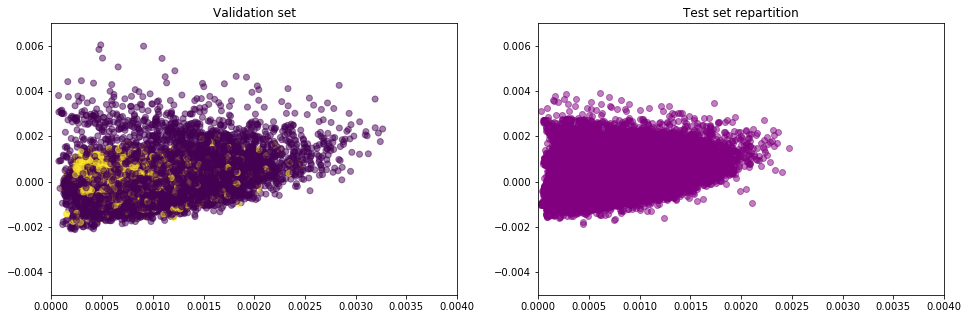

In [23]:
plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
plt.xlim([0, 4e-3]); plt.ylim([-5e-3, 7e-3]); plt.title('Validation set')
plt.scatter(x_valid[:,6], x_valid[:,7], c=y_patches_lab_val, alpha=0.5)
plt.subplot(1,2,2)
plt.xlim([0, 4e-3]); plt.ylim([-5e-3, 7e-3]); plt.title('Test set repartition')
plt.scatter(x_test[:,6], x_test[:,7], c='purple', alpha=0.5)

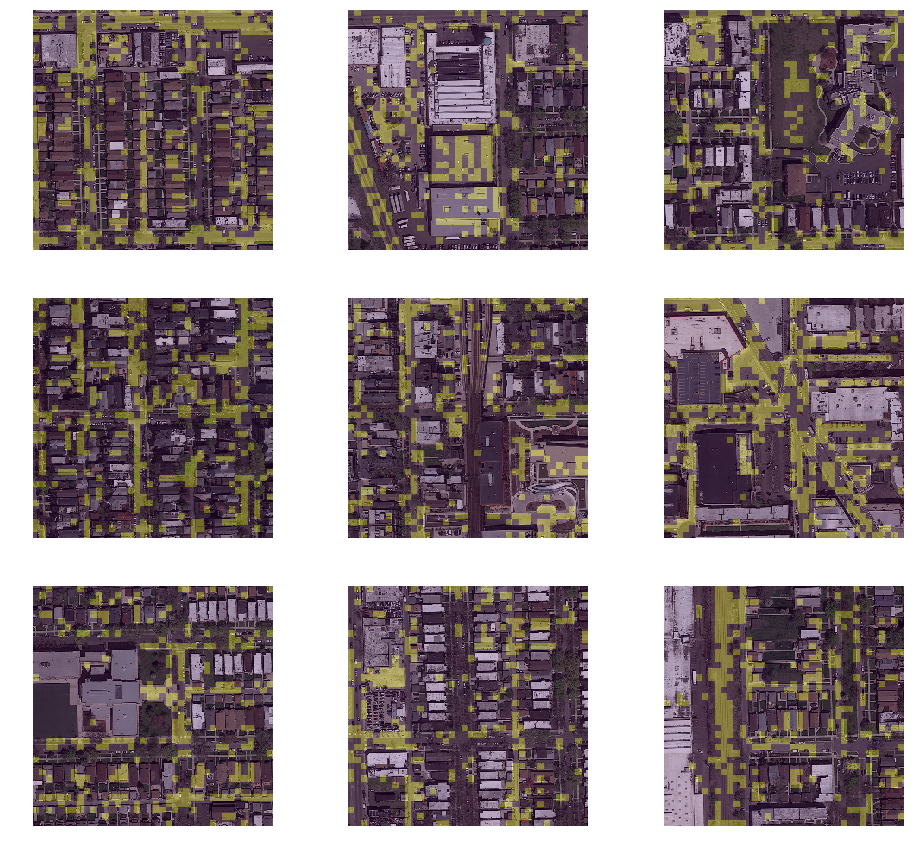

In [16]:
id_display = [0, 1, 2, 20, 21, 22, 40, 41, 42]

plt.figure(figsize=(16, 5*(len(id_display)//3)))
for i, id_ in enumerate(id_display):
    # Get source image and predction for current id
    im = ml_utils.load_image_test_by_id(id_+1, path_data)
    pred_label = ml_utils.patches_to_img(y_pred[id_*(38*38):(id_+1)*(38*38)], im.shape)
    plt.subplot(len(id_display)//3, 3, i+1)
    plt.imshow(im); plt.imshow(pred_label, alpha=0.3); plt.axis('off');

Create submission file for test evaluation

In [17]:
ml_utils.create_submission(y_pred, 'test_submission.csv')